#

In [2]:
# Copyright 2023 Shane Khalid. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================License.

In [1]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import math
import datetime
import keras
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

%matplotlib inline

2023-10-28 00:03:07.297103: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 00:03:07.297159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 00:03:07.298682: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 00:03:07.444856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tensorflow import keras

from keras.layers import GRU, Dropout, SimpleRNN, LSTM, Dense, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and being used.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead.")

2023-10-28 00:04:17.521101: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 00:04:17.549403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-28 00:04:17.549462: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:43:00.0/numa_node
Your kernel may have been built without NUMA support.


Num GPUs Available:  1
GPU is available and being used.


In [5]:
GOOGL_df = yf.download("GOOGL", start="2010-01-01", end="2023-10-28")
GOOGL_df


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...
2023-10-23,135.039993,137.660004,133.949997,136.500000,136.500000,26317900
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200


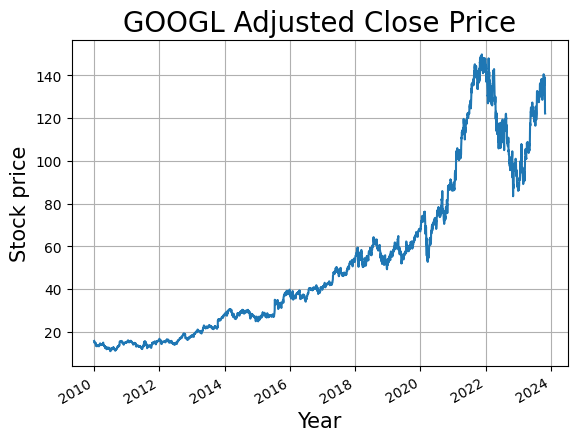

In [6]:
# Plot Adjusted Close Price

GOOGL_df['Adj Close'].plot(grid = True)
sns.set(rc={'figure.figsize':(16, 8)})
plt.title('GOOGL Adjusted Close Price', color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock price', color = 'black', fontsize = 15);

In [7]:
# Create dataframe for Adjusted Close Price

GOOGL_adj = GOOGL_df[['Adj Close']]
GOOGL_adj

,Adj Close
Date,
2010-01-04,15.684434
2010-01-05,15.615365
2010-01-06,15.221722
2010-01-07,14.867367
2010-01-08,15.065566
...,...
2023-10-23,136.500000
2023-10-24,138.809998
2023-10-25,125.610001


### Step 4. Create Training Dataset
##### 80% Training set

In [9]:
# Convert DataFrame to numpy array
GOOGL_adj_arr = GOOGL_adj.values

# Find number of rows to train model on (80% of data set) 
training_data_len = int(0.8*len(GOOGL_adj))

training_data_len
     

2783

In [10]:
# Create train data set
train = GOOGL_adj_arr[0:training_data_len, :]


Feature scaling
We will normalise the training data before model fitting by converting the values of numeric columns in the data set to a common scale. Scikit-Learn’s MinMaxScaler() function scales the data to values between 0 and 1 which helps boost performance.

In [11]:
# Normalise the data
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train)

train_scaled

array([[0.05699996],
       [0.05617491],
       [0.05147275],
       ...,
       [0.99254024],
       [0.994977  ],
       [1.        ]])

In [12]:
train_scaled.shape

(2783, 1)

Split training data into X_train, y_train

In [29]:
# Creating a data structure with 60 time-steps and 1 output

# Split data into X_train and y_train data sets
X_train = []
y_train = []
# Creating a data structure with 165 time-steps and 1 output
for i in range(165, len(train_scaled)):
    X_train.append(train_scaled[i-165:i, 0])
    y_train.append(train_scaled[i:i+1, 0])  
    if i <= 166:     # 165 days for first pass, 166 for second
      print(X_train)
      print(y_train)
      print()

[array([0.05699996, 0.05617491, 0.05147275, 0.04723989, 0.04960743,
       0.0493354 , 0.04615778, 0.0451444 , 0.04596945, 0.04302499,
       0.04530283, 0.04314754, 0.0439158 , 0.03406008, 0.03106779,
       0.03179119, 0.03169554, 0.0293609 , 0.02806055, 0.02898125,
       0.02841329, 0.0313129 , 0.02711593, 0.02846411, 0.02911577,
       0.03000359, 0.02940873, 0.02999163, 0.02901114, 0.0314564 ,
       0.0305327 , 0.03203034, 0.03129497, 0.03190479, 0.02959405,
       0.02851791, 0.02701131, 0.0271219 , 0.02888261, 0.03138465,
       0.0326581 , 0.03542918, 0.03830487, 0.03778773, 0.03710319,
       0.04196379, 0.04336577, 0.04288748, 0.03799698, 0.03860082,
       0.03870844, 0.03895954, 0.03704639, 0.03629906, 0.03375816,
       0.03624824, 0.03790731, 0.03785051, 0.03777876, 0.03905221,
       0.03917477, 0.03967696, 0.04033761, 0.03950359, 0.0381046 ,
       0.03928537, 0.03890574, 0.04085177, 0.04504874, 0.04571536,
       0.04759861, 0.03410193, 0.03408697, 0.03556369, 0.0353

In [33]:
# Convert X_train and y_train to numpy arrays for training LSTM model
X_train, y_train = np.array(X_train), np.array(y_train)

In [34]:
# Reshape the data as LSTM expects 3-D data (samples, time steps, features)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2618, 165, 1)

Create and train model
We will create and train a model with four recurrent layers each with 50 neurons, input shape of data with number of time steps (60) and dimensionality (1), and an output layer with time step of 1, and the tanh activation function. Dropout will be used after each hidden layer as a regularisation technique to prevent overfitting. The model will be compiled using the Mean Squared Error loss function and the adam (Adaptive Moment Estimation) optimizer then fitted on the training set for 200 epochs with a batch size of 64.

In [35]:
# Build model - LSTM with 50 neurons and 4 hidden layers  

LSTM_model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1), activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, return_sequences = True, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
LSTM_model.add(LSTM(units = 50, activation='tanh'))
LSTM_model.add(Dropout(0.2))
# Adding the output layer
LSTM_model.add(Dense(units = 1))

LSTM_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 165, 50)           10400     
                                                                 
 dropout_8 (Dropout)         (None, 165, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 165, 50)           20200     
                                                                 
 dropout_9 (Dropout)         (None, 165, 50)           0         
                                                                 
 lstm_10 (LSTM)              (None, 165, 50)           20200     
                                                                 
 dropout_10 (Dropout)        (None, 165, 50)           0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

In [36]:
# Compiling the LSTM
LSTM_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['F1Score', 'Accuracy', 'Precision'])
# Fitting the RNN to the Training set
LSTM_model.fit(X_train, y_train, epochs = 200, batch_size = 64)

Epoch 1/200
41/41 [==============================] - 7s 58ms/step - loss: 0.0170 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 2/200
41/41 [==============================] - 2s 57ms/step - loss: 0.0028 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 3/200
41/41 [==============================] - 2s 55ms/step - loss: 0.0025 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 4/200
41/41 [==============================] - 2s 55ms/step - loss: 0.0024 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 5/200
41/41 [==============================] - 2s 55ms/step - loss: 0.0020 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 6/200
41/41 [==============================] - 2s 57ms/step - loss: 0.0021 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000
Epoch 7/200
41/41 [==============================] - 2s 52ms/step - loss: 0.0019 - f1_score: 0.4908 - Accuracy: 3.8197e-04 - precision: 1.0000

In [37]:
LSTM_model.save('LSTM_model-Module2.keras')

#### Create Test Set

In [38]:
test = GOOGL_adj_arr[training_data_len: , :]
test.shape

(696, 1)

#### Going to do something interesting this time. Let's see if we can predict the 696 values, using 165 from the Train Data

In [39]:
inputs = GOOGL_adj_arr[len(GOOGL_adj_arr) - len(test) - 165:]
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [40]:
# Create data sets X_test and y_test

X_test = []
y_test = GOOGL_adj_arr[training_data_len:, :]
for i in range(165,inputs.shape[0]):
    X_test.append(inputs[i-165:i,0])

In [41]:
# Convert df back to numpy array

X_test = np.array(X_test)

In [42]:
# Reshape data into 3D (because LSTM)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [43]:
print(X_test.shape)

(696, 165, 1)


#### Make Predictions using the test set

In [44]:
# We want predictions to contain same values as y_test data set
predictions = LSTM_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

22/22 [==============================] - 1s 31ms/step


In [45]:
predictions.shape

(696, 1)

Calculate the RMSE using the actual values
RMSE is the standard deviation of the residuals and is a good measure of how accurately the model predicts the reponse. Lower values of RMSE indicate a better fit.

In [46]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)  
rmse

0.34031946905728044

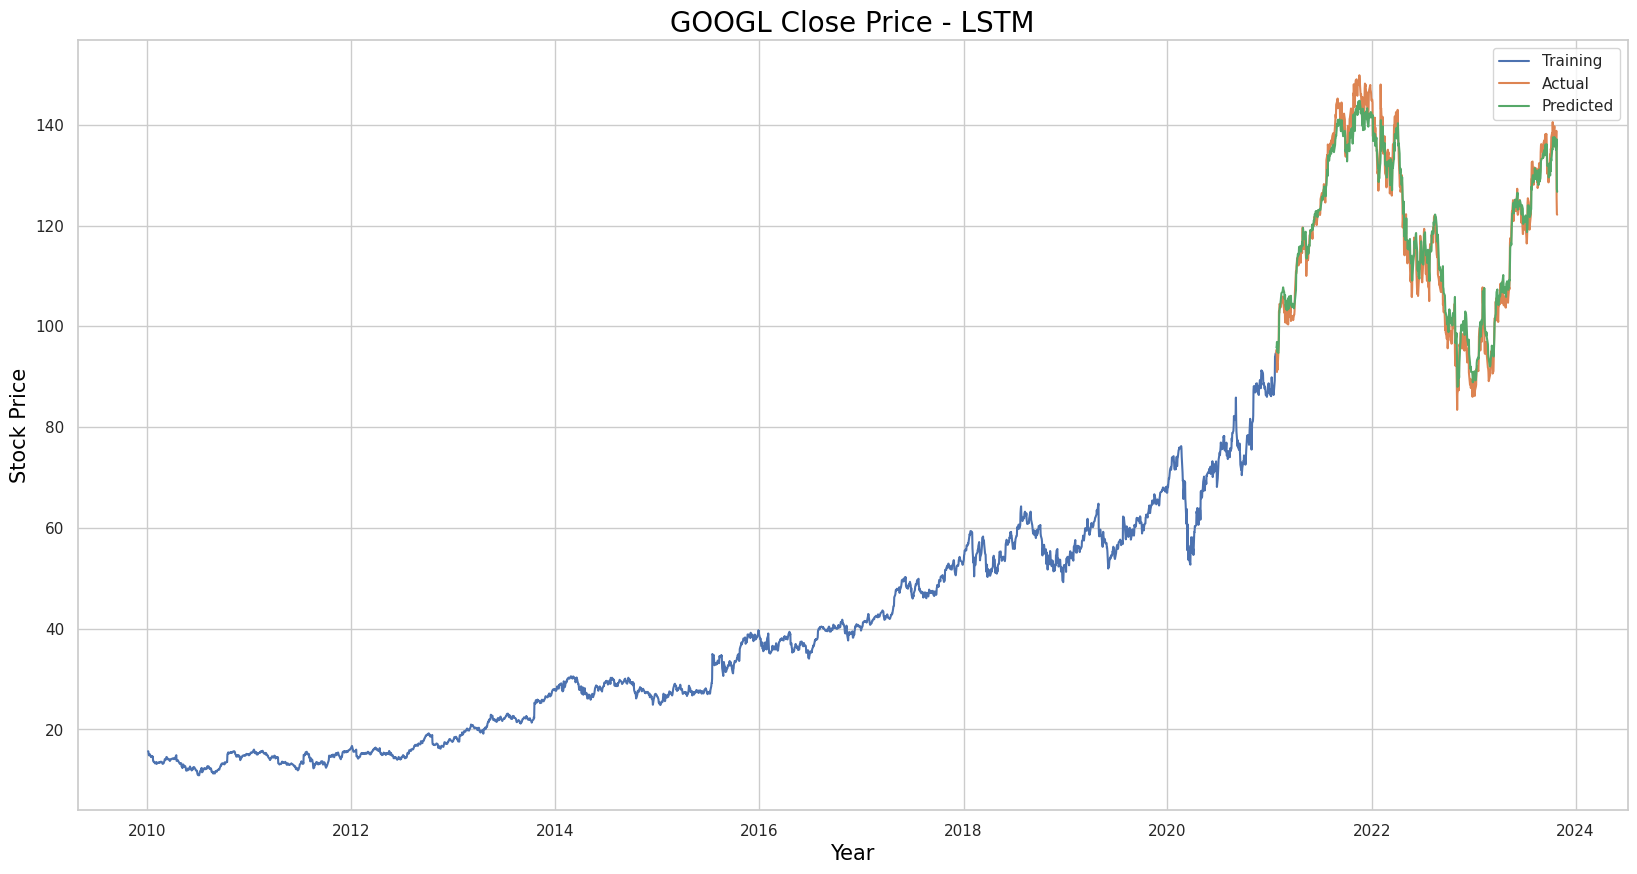

In [47]:
# Plot predicted vs actual values  
train = GOOGL_adj[:training_data_len]
test = GOOGL_adj[training_data_len:]
test['Predictions'] = predictions

plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.plot(train['Adj Close'], label='Training')
plt.plot(test['Adj Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("GOOGL Close Price - LSTM", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Stock Price', color = 'black', fontsize = 15)
plt.legend();

DataFrame of actual vs predicted prices plotted above

In [48]:
# Show the actual and predicted prices  

test

,Adj Close,Predictions
Date,,
2021-01-25,94.713997,95.802765
2021-01-26,95.397499,96.042114
2021-01-27,90.946999,96.911560
2021-01-28,92.660004,94.933029
2021-01-29,91.367996,95.021492
...,...,...
2023-10-23,136.500000,135.039429
2023-10-24,138.809998,136.071472
2023-10-25,125.610001,137.144012


#### Predict Adjusted Close price for October 27th 2023

In [51]:
# Predict Adjusted Close price for GOOGL stock for October 27th 2023   
# get the quote
GOOGL_quote = yf.download("GOOGL", start="2015-07-10", end="2023-10-27")
# Create new df
new_df = GOOGL_quote.filter(['Adj Close'])
# Get last 165 days closing price and convert df to array])
last_165_days = new_df[-165:].values
# Scale data to be values between 0 and 1
last_165_days_scaled = scaler.transform(last_165_days)
# Create empty list
X_test = []
# Append last 165 days 
X_test.append(last_165_days_scaled)
# Convert the X_test data set to numpy array
X_test = np.array(X_test)
# Reshape data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# Get predicted price
pred_price = LSTM_model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 36ms/step
[[126.71151]]


#### Actual Adjusted Close price for Octoebr 27th, 2023

In [52]:
# Actual price
GOOGL_quote2 = yf.download("GOOGL", start="2023-10-26", end="2023-10-27")
print(GOOGL_quote2['Adj Close'])

[*********************100%%**********************]  1 of 1 completed
Date
2023-10-26    122.279999
Name: Adj Close, dtype: float64


#### As you can see, the predicted adjusted close price for 10/27/2023 was $126.71151 while the actual price was 122.279999. This is a 3.55957% difference. 